# Instalação das bibliotecas necessárias para a CNN

In [ ]:
!pip install split_folders
!pip install "torch==1.4" "torchvision==0.5.0"

# Montagem do disco do Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


# Atribuição da variável PATH, na qual contém as pastas separadas por típo

In [ ]:
PATH = '/content/gdrive/MyDrive/covid-dataset/data/'

# CNN que irá classificar as imagens entre "Covid" e "Não-Covid"

Copying files: 4228 files [36:13,  1.95 files/s]
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 2.29E-05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.966472,0.669869,0.570866,0.429134,08:58
1,0.408752,0.200114,0.631496,0.368504,09:25
2,0.286686,0.190142,0.649606,0.350394,09:22
3,0.204099,0.202489,0.674016,0.325984,09:17
4,0.202745,0.174309,0.672441,0.327559,09:17


Better model found at epoch 0 with accuracy value: 0.5708661675453186.
Better model found at epoch 1 with accuracy value: 0.6314960718154907.
Better model found at epoch 2 with accuracy value: 0.6496062874794006.
Better model found at epoch 3 with accuracy value: 0.6740157604217529.


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 6.31E-04


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.208259,0.163515,0.682677,0.317323,11:59
1,0.198716,0.169202,0.685039,0.314961,11:56
2,0.197172,0.182239,0.679528,0.320472,11:59
3,0.187615,0.172034,0.671654,0.328346,11:40
4,0.199863,0.197301,0.660630,0.339370,11:39
5,0.198031,0.175590,0.681890,0.318110,11:40
6,0.187498,0.186782,0.677953,0.322047,11:40
7,0.181894,0.159626,0.681102,0.318898,11:42
8,0.172543,0.191089,0.674016,0.325984,11:42
9,0.166182,0.181356,0.684252,0.315748,11:43


Better model found at epoch 0 with accuracy value: 0.682677149772644.
Better model found at epoch 1 with accuracy value: 0.6850393414497375.
Better model found at epoch 13 with accuracy value: 0.6866141557693481.


valid_loss: 0.1762727 accuracy: 0.6866141557693481 error_rate: 0.31338581442832947


IsADirectoryError: ignored

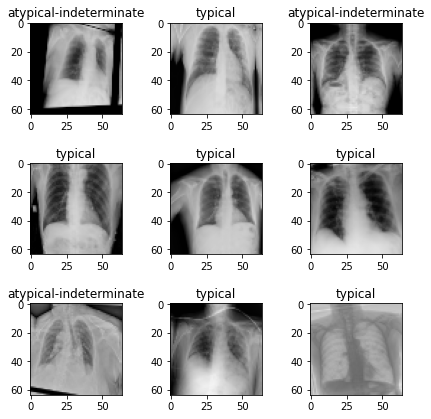

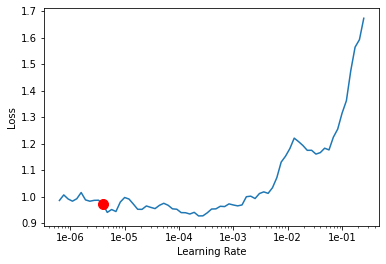

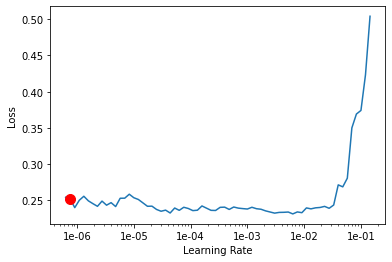

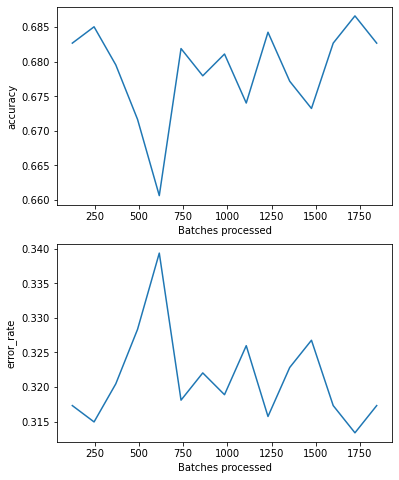

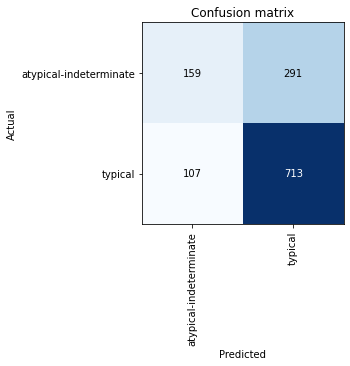

In [ ]:
#Densenet-161 :

import numpy as np # linear algebra
import pandas as pd # data processing
from fastai import *
import os
from tqdm import tqdm
from fastai import *
import torch
from fastai.vision import *
%matplotlib inline
from fastai.callbacks import *
import cv2
import pandas as pd
import splitfolders
image_load_size = 64
bs = 24
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True    

SEED = 999
seed_everything(SEED)
splitfolders.ratio(PATH, output=PATH, seed=SEED, ratio=(.7, .3))
tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])
data = (ImageList.from_folder(path=PATH)
        .split_by_folder(train='train',valid='val')
        .label_from_folder()
        .transform(tfms,size = image_load_size,resize_method=ResizeMethod.SQUISH)
        .databunch(path='.',bs=bs)    
        .normalize(imagenet_stats)
)
data.show_batch(3, figsize=(6,6), hide_axis=False)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
model = cnn_learner(data,models.densenet161, metrics = [accuracy,error_rate],callback_fns=[partial(SaveModelCallback, monitor='accuracy', name='vgg')])
model.loss_func = FocalLoss()
model.summary()
model.lr_find()
model.recorder.plot(suggestion = True)

lr = 2e-3
model.fit_one_cycle(5,slice(lr))
model.unfreeze()
model.lr_find()
model.recorder.plot(suggestion = True)
model.fit_one_cycle(15,slice(1e-6,lr/10))
model.recorder.plot_metrics()
valid_loss_save_model,accuracy_save_model, error_rate_save_model = model.validate(model.data.valid_dl)
print('valid_loss:', valid_loss_save_model, 'accuracy:', float(accuracy_save_model),'error_rate:',float(error_rate_save_model))
interpreter = ClassificationInterpretation.from_learner(model)
interpreter.plot_confusion_matrix(figsize = (5,5))
#Predict results
pred = model.predict(open_image(PATH))
print(pred[0],pred[1],pred[2])